In [1]:
%load_ext autoreload
%autoreload 2
import glob
import numpy as np
from sklearn.metrics import r2_score
from sklearn import preprocessing
import xgboost as xgb
from collections import defaultdict
from matplotlib import pyplot as plt
import pandas as pd
from itertools import product
np.random.seed(42)

In [2]:
file1 = '../datasets/genotype/cas9/10nm/pnas.1700557114.sd01.txt'
file2 = '../datasets/genotype/cas9/10nm/pnas.1700557114.sd02.txt'
file3 = '../datasets/genotype/cas9/10nm/pnas.1700557114.sd03.txt'
file4 = '../datasets/genotype/cas9/10nm/pnas.1700557114.sd04.txt'
file5 = '../datasets/genotype/cas9/1nm/pnas.1700557114.sd05.txt'
file6 = '../datasets/genotype/cas9/1nm/pnas.1700557114.sd06.txt'

In [3]:
gene = "GACGCATAAAGATGAGACGCTGG"
pair2int = {pair: idx for  idx, pair in enumerate(product(['A', 'C', 'G', 'T'], ['A', 'C', 'G', 'T']))}

In [4]:
print(pair2int)

{('A', 'A'): 0, ('A', 'C'): 1, ('A', 'G'): 2, ('A', 'T'): 3, ('C', 'A'): 4, ('C', 'C'): 5, ('C', 'G'): 6, ('C', 'T'): 7, ('G', 'A'): 8, ('G', 'C'): 9, ('G', 'G'): 10, ('G', 'T'): 11, ('T', 'A'): 12, ('T', 'C'): 13, ('T', 'G'): 14, ('T', 'T'): 15}


In [5]:
letter2int = {'A':1, 'C':2, 'G':3, 'T':4}

def read_cas9_dataset(files):
    signal_original = defaultdict(list) 
    signal_pair = defaultdict(list)
    
    for file in files:
        with open(file, 'r') as f:
            for line in f.readlines()[1:]:
                tokens = line.split('\t')
                signal_original[tokens[2]] += [float(tokens[5])]
                key = np.asarray([pair2int[(base, base)] for base in gene])
                if int(tokens[3]) > 0:
                    positions = np.asarray([int(pos[:-1]) for pos in tokens[2].split(':')])
                    values = np.asarray([pair2int[(gene[int(pos[:-1])], pos[-1])] for pos in tokens[2].split(':')])
                    key[positions] = values 
                key = tuple(key.tolist())
                signal_pair[key] += [float(tokens[5])]
                
        
    X = np.asarray(list(signal_pair.keys()))
    Y = np.asarray([np.mean(signal_pair[key]) for key in signal_pair.keys()])
    return X, Y, signal_original, signal_pair

In [6]:
X, Y, s1, s_hamming = read_cas9_dataset([file1, file2, file3, file4])#, file5, file6])
counts = np.asarray([len(val) for key, val in s_hamming.items()])
means = np.asarray([np.mean(s_hamming[key]) for key in s_hamming.keys()])
stds = np.asarray([np.std(s_hamming[key]) for key in s_hamming.keys()])
#mask = 2*stds < np.abs(means)
mask = counts > 3 # for 1 nm data here I used 0 instead of 3
means_better = means[mask]
X = X[mask]
Y = Y[mask]
#X = X > 0 

train_fraction = 0.8
valid_fraction = 0.1

scaler = preprocessing.StandardScaler().fit(Y[:, np.newaxis])
Y = scaler.transform(Y[:, np.newaxis])[:, 0]
n_train = int(len(X)*train_fraction)
n_valid = int(len(X)*valid_fraction)
perm = np.random.permutation(len(X))
X_train = X[perm[:n_train]]
X_valid = X[perm[n_train:n_train+n_valid]]
X_test = X[perm[n_train+n_valid:]]
Y_train = Y[perm[:n_train]]
Y_valid = Y[perm[n_train:n_train+n_valid]]
Y_test = Y[perm[n_train+n_valid:]]

In [7]:
X

array([[ 8,  0,  4, ..., 15, 10, 10],
       [ 8,  0,  4, ..., 15, 10, 10],
       [ 8,  0,  4, ..., 15, 10, 10],
       ...,
       [11,  3,  7, ..., 15, 10, 10],
       [11,  3,  7, ..., 14, 10, 10],
       [11,  3,  7, ..., 15, 10, 10]])

In [8]:
counts = np.asarray([len(val) for key, val in s_hamming.items()])

In [9]:
mask.sum()

9094

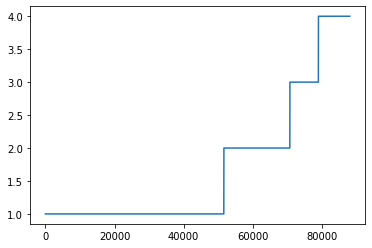

In [10]:
plt.plot(sorted(counts))

In [11]:
est = xgb.XGBRegressor(n_estimators=100)

In [12]:
est.fit(X_train, Y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [13]:
Y_pred = est.predict(X_test)
Y_pred2 = est.predict(X_train)
r2_train = r2_score(Y_train, Y_pred2)
rel_train = np.linalg.norm(Y_train - Y_pred2)/np.linalg.norm(Y_train)
r2 = r2_score(Y_test, Y_pred)
rel = np.linalg.norm(Y_test - Y_pred)/np.linalg.norm(Y_test)

In [14]:
print('TRAIN  R2 score: %2.4f, relative error: %2.4f'%(r2_train, rel_train))
print('TEST   R2 score: %2.4f, relative error: %2.4f'%(r2, rel))

TRAIN  R2 score: 0.5475, relative error: 0.6726
TEST   R2 score: 0.3277, relative error: 0.8174


In [15]:
# X>0:
# XGboost default: 
#  TRAIN  R2 score: 0.3371, relative error: 0.8142
#  TEST   R2 score: 0.1386, relative error: 0.9277

# X hamming:
# XGBoost default:
#  TRAIN  R2 score: 0.4170, relative error: 0.7635
#  TEST   R2 score: 0.1574, relative error: 0.9176

In [16]:
Y

array([-0.80207293,  0.45165686, -0.19344233, ..., -1.31922356,
        0.5473373 ,  0.43708858])

In [17]:
def save_csv(X, Y, name):
    df = {}
    for idx, feat in enumerate(X.T):
        df['pos%d'%idx] = feat
    df['y'] = Y
    df = pd.DataFrame(df)
    df.to_csv(name)

In [18]:
save_csv(X, Y, 'cas9_pairs_10nm_full.csv')
save_csv(X_train, Y_train, 'cas9_pairs_10nm_train.csv')
save_csv(X_valid, Y_valid, 'cas9_pairs_10nm_valid.csv')
save_csv(X_test, Y_test, 'cas9_pairs_10nm_test.csv')

In [20]:
X.shape

(9094, 23)